# College Football Analysis Using Aggregated Team Data


***
### Summary

This notebook explores college football game data by team for games since 2010. More specifically, it evaluates the relationships between certain features and predicting wins towards the end of a given season. The goal of this analysis is to better understand what specific statistics about a team can be reliably looked at as indicators for the potential to win.

The first part will look at features that will accurately classify a game as Won by a given team. The second part will take the findings from the first model to identify the proper values that need to be predicted. The end product will be a predictive model comprised of two models, one that predicts the feature values based on past performance and oppenents past performance, that are then fed into another model that classifies that game as a Win or Lost based on those values predicted.

ESPN claims their power index is accurate >70% of the time, so this will be the threshold that this analysis will benchmark off of.

In [2]:
#imports used
import pandas as pd
from bqAutoAuth import bqClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from random import randint


***
### Data Gathering and Transformations

The data used is webscraped and dropped into bigquery for easy access. It is continuously updated every week during football season. The code for this ETL process is within the Data Pipeline project.

In [3]:
client = bqClient()#this function creates a bigquery Client object and will check default authentication for the google SDK CLI and prompt authentication if none is detected.
qs = """SELECT * FROM `portfolio-project-353016.collegeFootball.Game_Team_Stats` WHERE PossTime LIKE '%:%' AND GameID != '302750030' """#light cleaning within the query
teamStats_df = client.query(qs).result().to_dataframe()
teamStats_df.head()


successful gcloud authentication check


,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,Penalties,FumblesLost,PossTime
0,312952628,New Mexico Lobos,False,0,5,1-12,0-1,85,34,8-11,0,64,37,7-50,3,18:22
1,400935387,Rutgers Scarlet Knights,True,14,8,3-15,0-0,217,87,9-18,0,130,37,4-35,0,27:54
2,312950135,Minnesota Golden Gophers,True,14,11,7-15,1-2,254,122,9-18,0,132,39,5-55,1,17:28
3,302960238,Vanderbilt Commodores,True,7,11,3-15,1-3,250,145,13-31,0,108,30,4-40,0,13:59
4,400869141,Arizona State Sun Devils,True,32,12,7-15,1-1,280,167,14-24,0,113,35,4-40,1,27:05


We want to split up fields that are a combination of two stats such as PassCompAtt or ThirdDownEff. This will allow us greater flexibility in feature engineering later on.

In [4]:
for c in ['ThirdDownEff', 'FourthDownEff', 'PassCompAtt', 'Penalties']:
    teamStats_df[[c, f'{c}Den']] = teamStats_df[c].str.split(pat='-', expand=True)

teamStats_df['PossTime'] = pd.Series([float(val.split(':')[0]) + round(int(val.split(':')[1])/60,2) for val in teamStats_df['PossTime'] if val != 'unavail'])
teamStats_df.head()

,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,Penalties,FumblesLost,PossTime,ThirdDownEffDen,FourthDownEffDen,PassCompAttDen,PenaltiesDen
0,312952628,New Mexico Lobos,False,0,5,1,0,85,34,8,0,64,37,7,3,18.37,12,1,11,50
1,400935387,Rutgers Scarlet Knights,True,14,8,3,0,217,87,9,0,130,37,4,0,27.90,15,0,18,35
2,312950135,Minnesota Golden Gophers,True,14,11,7,1,254,122,9,0,132,39,5,1,17.47,15,2,18,55
3,302960238,Vanderbilt Commodores,True,7,11,3,1,250,145,13,0,108,30,4,0,13.98,15,3,31,40
4,400869141,Arizona State Sun Devils,True,32,12,7,1,280,167,14,0,113,35,4,1,27.08,15,1,24,40


The main table being used contains a record for each team per game, with their respective stats for that game. These fields are offensively focused, but we can infer defensive fields by executing a self join with the opposing team for each game (E.g. the home team's pass yards is the away team's pass yards allowed). Additionally, ensuring all fields have the correct data type will help further prep for analysis. Furthermore, we want to convert time of possession from minutes and seconds to minutes represented as a float.

In [5]:
TShome_df = teamStats_df[teamStats_df['isHome'] == True].copy()
TSaway_df = teamStats_df[teamStats_df['isHome'] == False].copy()

colMap = { 
    'Points': 'PointsAllowed', 
    'FirstDowns': 'FirstDownsAllowed', 
    'ThirdDownEff': 'ThirdDownAllowed',
    'ThirdDownEffDen': 'ThirdDownAllowedDen',
    'FourthDownEff': 'FourthDownAllowed',
    'FourthDownEffDen': 'FourthDownAllowedDen', 
    'TotalYds': 'TotalYdsAllowed', 
    'PassYds': 'PassYdsAllowed', 
    'PassCompAtt': 'PassCompAttAllowed',
    'PassCompAttDen': 'PassCompAttAllowedDen', 
    'PassIntThrown': 'PassInt', 
    'RushYds': 'RushYdsAllowed', 
    'RushAtt': 'RushedAgainstAtt'
 }

keepcol = [
    'GameID',
    'PointsAllowed', 
    'FirstDownsAllowed', 
    'ThirdDownAllowed', 
    'ThirdDownAllowedDen',
    'FourthDownAllowed', 
    'FourthDownAllowedDen',
    'TotalYdsAllowed', 
    'PassYdsAllowed', 
    'PassCompAttAllowed', 
    'PassCompAttAllowedDen',
    'PassInt', 
    'RushYdsAllowed', 
    'RushedAgainstAtt'
]

intcols = [
    "Points",
    "FirstDowns",
    "ThirdDownEff",
    "FourthDownEff",
    "TotalYds",
    "PassYds",
    "PassCompAtt",
    "PassIntThrown",
    "RushYds",
    "RushAtt",
    "Penalties",
    "FumblesLost",
    "ThirdDownEffDen",
    "FourthDownEffDen",
    "PassCompAttDen",
    "PenaltiesDen"
]

dtypes = {x: 'int64' for x in intcols}

TShome_df = TShome_df.astype(dtypes)
TSaway_df = TSaway_df.astype(dtypes)

homeAllowed_df = TSaway_df.copy()
homeAllowed_df = homeAllowed_df.astype(dtypes)
homeAllowed_df = homeAllowed_df.rename(columns=colMap)
homeAllowed_df = homeAllowed_df[keepcol]


awayAllowed_df = TShome_df.copy()
awayAllowed_df = awayAllowed_df.astype(dtypes)
awayAllowed_df = awayAllowed_df.rename(columns=colMap)
awayAllowed_df = awayAllowed_df[keepcol]


TShome_df = TShome_df.merge(homeAllowed_df, on='GameID')
TSaway_df = TSaway_df.merge(awayAllowed_df, on='GameID')

stats_df = pd.concat([TShome_df, TSaway_df], ignore_index=True)
stats_df.head()


,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,...,ThirdDownAllowedDen,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt
0,400935387,Rutgers Scarlet Knights,True,14,8,3,0,217,87,9,...,15,1,4,474,195,23,44,2,279,41
1,312950135,Minnesota Golden Gophers,True,14,11,7,1,254,122,9,...,17,3,3,515,169,14,23,0,346,56
2,302960238,Vanderbilt Commodores,True,7,11,3,1,250,145,13,...,17,0,0,484,367,31,39,1,129,45
3,400869141,Arizona State Sun Devils,True,32,12,7,1,280,167,14,...,13,1,1,346,398,42,53,0,-52,19
4,400869645,Penn State Nittany Lions,True,24,13,2,0,276,154,8,...,22,1,2,413,245,28,43,0,168,40


Now we want to identify winners by using a boolean flag.

In [6]:
stats_df['Won'] = stats_df['Points'] > stats_df['PointsAllowed']
stats_df.head()

,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,...,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt,Won
0,400935387,Rutgers Scarlet Knights,True,14,8,3,0,217,87,9,...,1,4,474,195,23,44,2,279,41,True
1,312950135,Minnesota Golden Gophers,True,14,11,7,1,254,122,9,...,3,3,515,169,14,23,0,346,56,False
2,302960238,Vanderbilt Commodores,True,7,11,3,1,250,145,13,...,0,0,484,367,31,39,1,129,45,False
3,400869141,Arizona State Sun Devils,True,32,12,7,1,280,167,14,...,1,1,346,398,42,53,0,-52,19,False
4,400869645,Penn State Nittany Lions,True,24,13,2,0,276,154,8,...,1,2,413,245,28,43,0,168,40,True


The data is now prepped for analysis.

***
### Exploratory Analysis, Feature Engineering and Model Selection

Using the describe method helps provide a high level understanding of each feature.

In [7]:
stats_df.describe()

,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,...,ThirdDownAllowedDen,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt
count,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,...,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000
mean,27.990586,20.544900,5.671943,0.798883,394.728636,233.927581,19.221498,0.893751,163.158908,37.849369,...,14.433478,0.798883,1.556900,394.728636,233.927581,19.221498,32.154459,0.893751,163.158908,37.849369
std,14.806670,5.993815,2.475681,0.953173,123.704118,97.569625,7.434813,0.969471,90.053366,9.640763,...,2.987779,0.953173,1.337168,123.704118,97.569625,7.434813,10.375707,0.969471,90.053366,9.640763
min,0.000000,2.000000,0.000000,0.000000,21.000000,-4.000000,0.000000,0.000000,-73.000000,6.000000,...,4.000000,0.000000,0.000000,21.000000,-4.000000,0.000000,1.000000,0.000000,-73.000000,6.000000
25%,17.000000,16.000000,4.000000,0.000000,306.000000,165.000000,14.000000,0.000000,98.000000,31.000000,...,12.000000,0.000000,1.000000,306.000000,165.000000,14.000000,25.000000,0.000000,98.000000,31.000000
50%,27.000000,20.000000,6.000000,1.000000,392.000000,227.000000,19.000000,1.000000,151.000000,37.000000,...,14.000000,1.000000,1.000000,392.000000,227.000000,19.000000,31.000000,1.000000,151.000000,37.000000
75%,38.000000,25.000000,7.000000,1.000000,477.000000,296.000000,24.000000,1.000000,218.000000,44.000000,...,16.000000,1.000000,2.000000,477.000000,296.000000,24.000000,39.000000,1.000000,218.000000,44.000000
max,84.000000,44.000000,20.000000,7.000000,872.000000,734.000000,58.000000,6.000000,581.000000,86.000000,...,27.000000,7.000000,9.000000,872.000000,734.000000,58.000000,89.000000,6.000000,581.000000,86.000000


Because there are so many features, we want to look at areas that seem to correlate.

C:\Users\ostee\AppData\Local\Temp\ipykernel_104140\173723342.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stats_df.corr(method='pearson')


<AxesSubplot: >

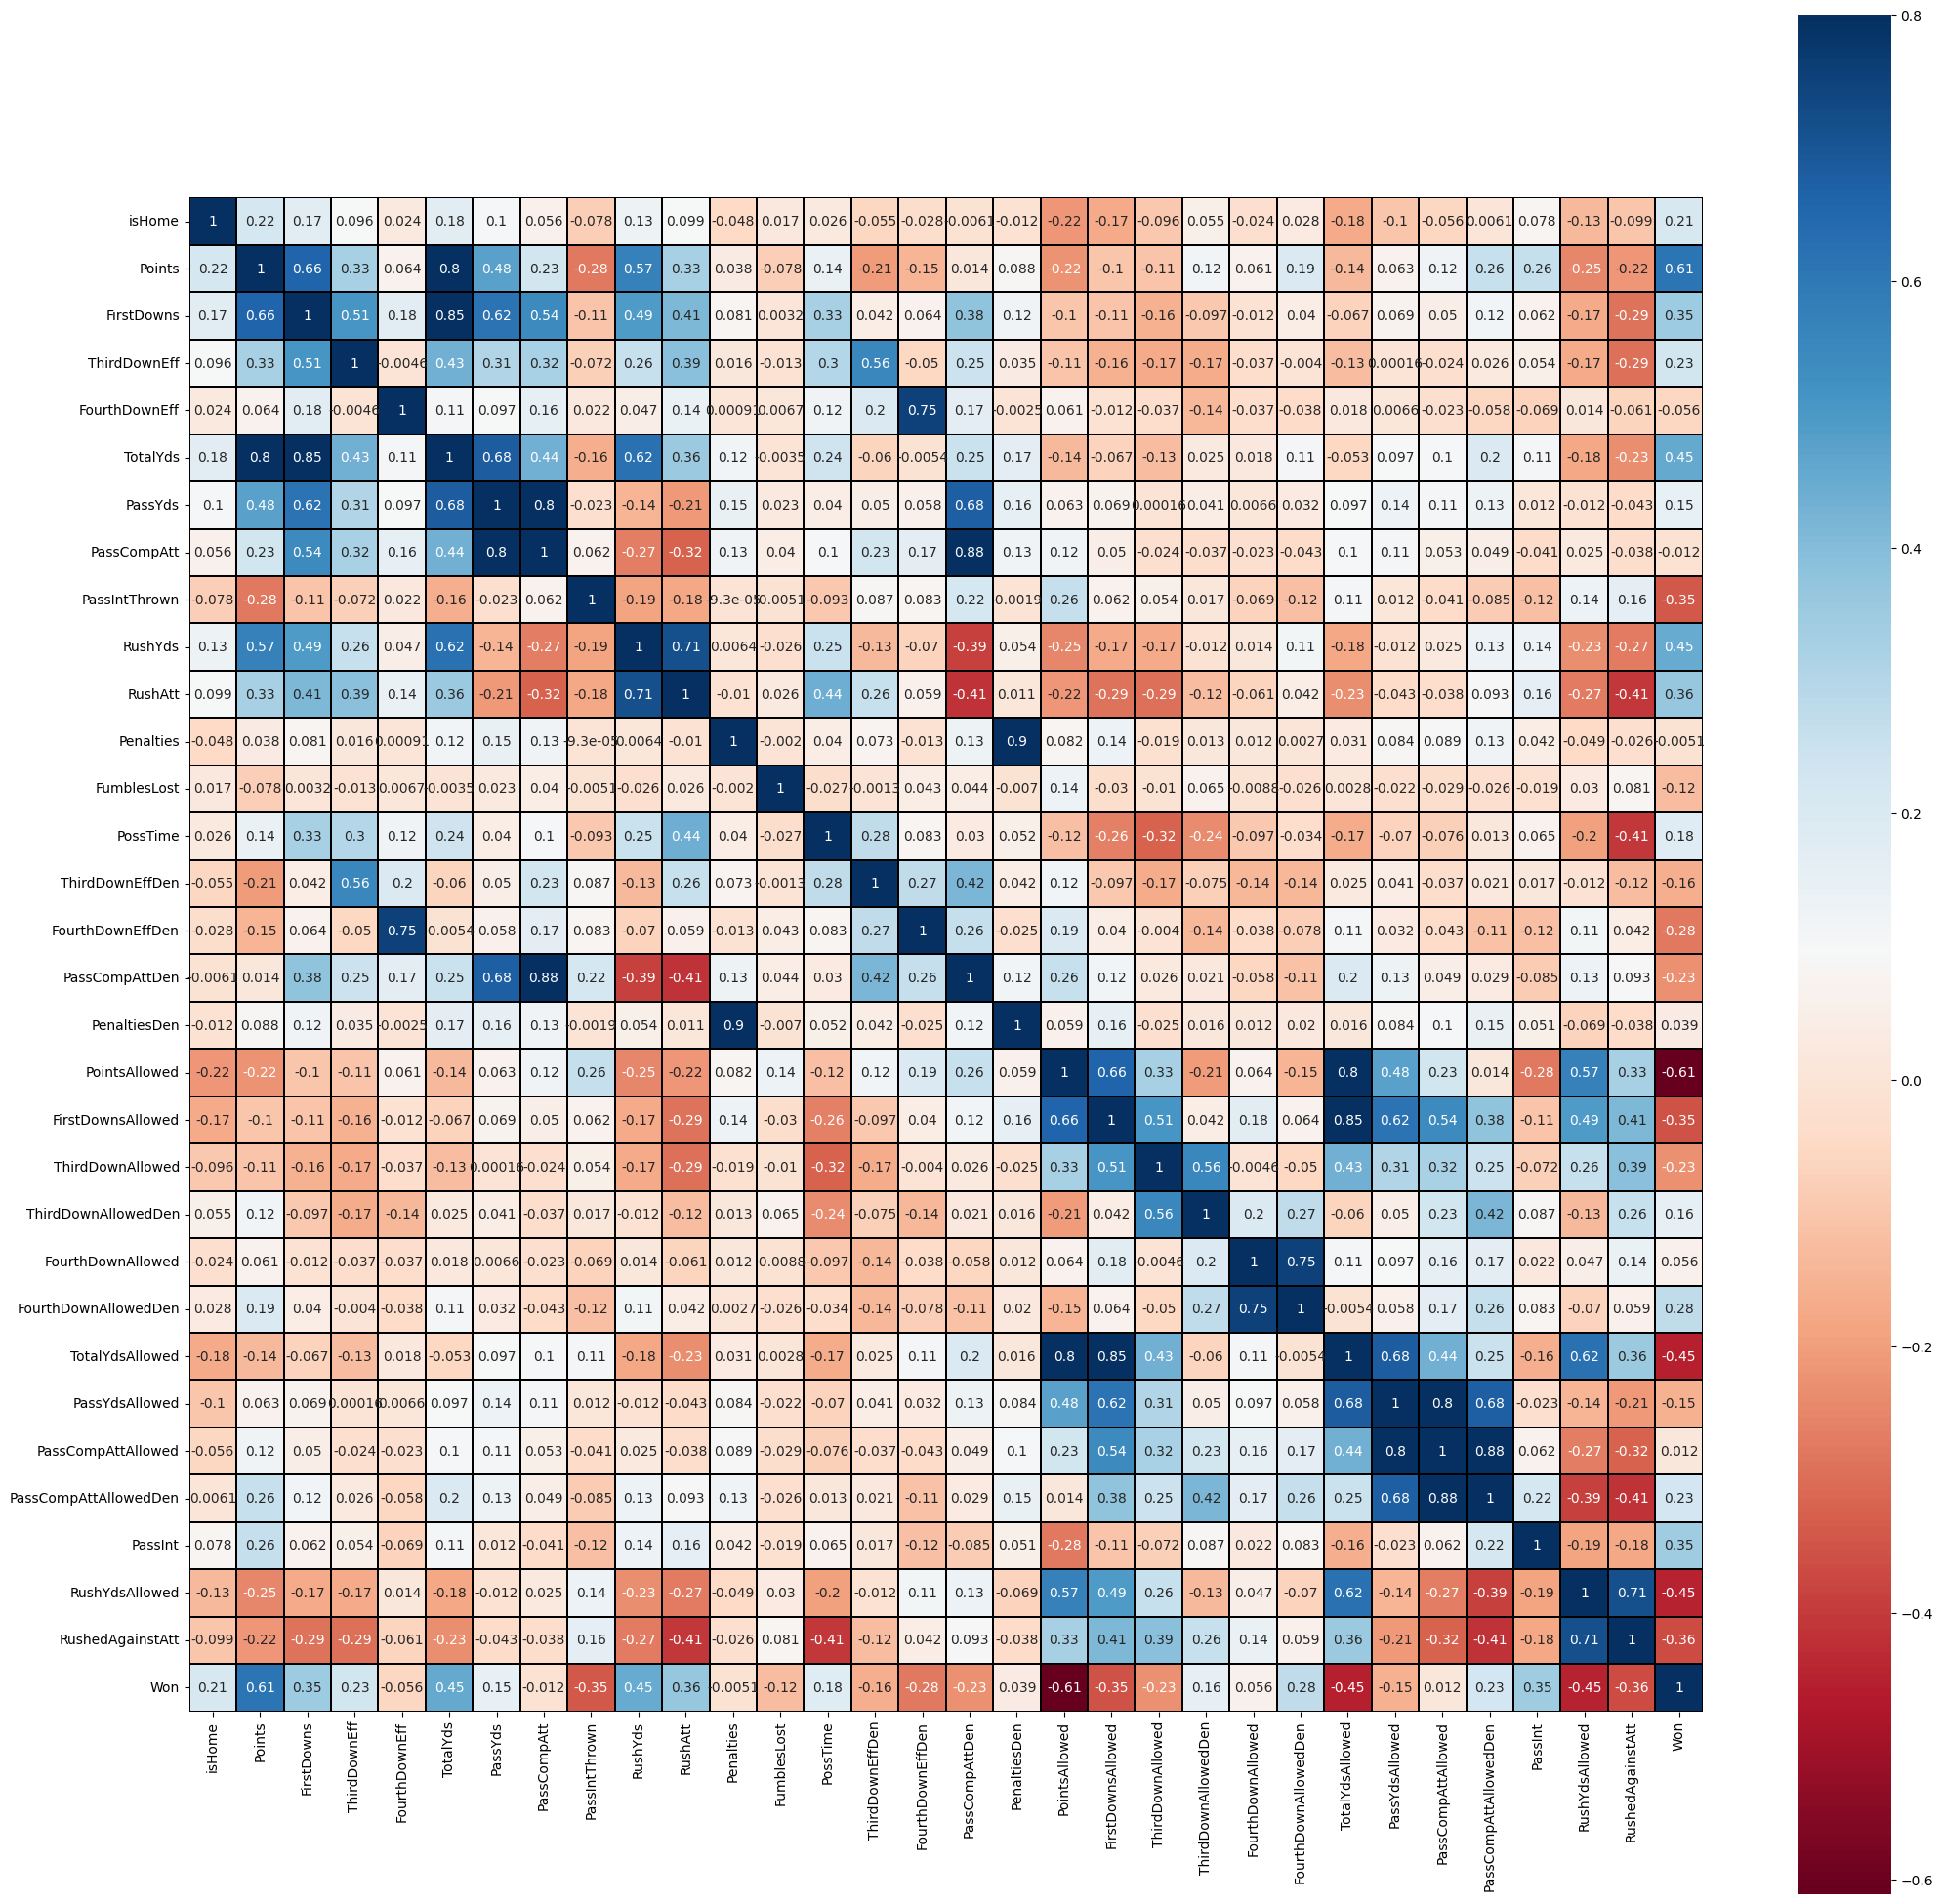

In [8]:
corr = stats_df.corr(method='pearson')
plt.figure(figsize=(25,25))
sn.heatmap(corr,vmax=.8,linewidths=0.01,square=True,annot=True,cmap='RdBu',linecolor='black')

While there are plenty of relationships that lean a certain way, there's not many that are very strong. To try and get some better insights, additional feature engineering is required.

<AxesSubplot: >

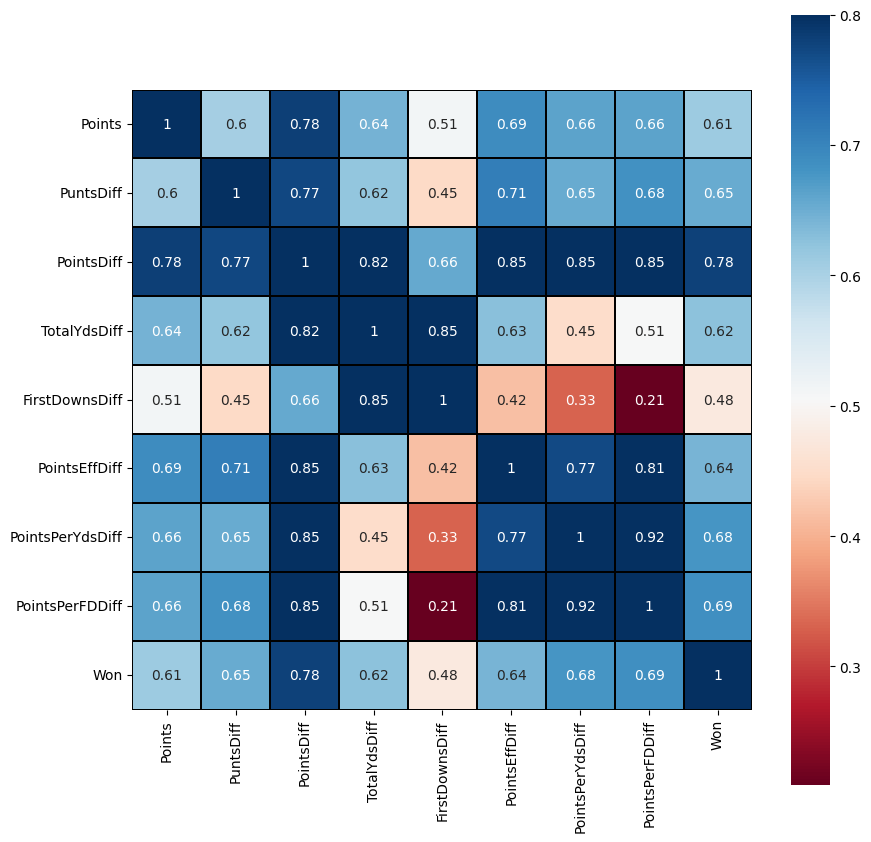

In [9]:
stats_df['Punts'] = (stats_df['ThirdDownEffDen']+stats_df['FourthDownEffDen']) - (stats_df['ThirdDownEff']+stats_df['FourthDownEff'])
stats_df['PuntsForced'] = (stats_df['ThirdDownAllowedDen']+stats_df['FourthDownAllowedDen']) - (stats_df['ThirdDownAllowed']+stats_df['FourthDownAllowed'])
stats_df['PuntsDiff'] = stats_df['PuntsForced'] - stats_df['Punts']
stats_df['PointsDiff'] = stats_df['Points'] - stats_df['PointsAllowed']
stats_df['TotalYdsDiff'] = stats_df['TotalYds'] - stats_df['TotalYdsAllowed']
stats_df['FirstDownsDiff'] = stats_df['FirstDowns'] - stats_df['FirstDownsAllowed']
stats_df['PossTimeAllowed'] = 60-stats_df['PossTime']
stats_df['PointsEff'] = round(stats_df['Points'] / stats_df['PossTime'],3)
stats_df['PointsEffAllowed'] = round(stats_df['PointsAllowed'] / stats_df['PossTimeAllowed'],3)
stats_df['PointsEffDiff'] = stats_df['PointsEff'] - stats_df['PointsEffAllowed']
stats_df['TotalYdsEff'] = round(stats_df['TotalYds'] / stats_df['PossTime'],3)
stats_df['TotalYdsEffAllowed'] = round(stats_df['TotalYdsAllowed'] / stats_df['PossTime'],3)
stats_df['PointsPerYd'] = round(stats_df['Points'] / stats_df['TotalYds'],3)
stats_df['PointsPerYdAllowed'] = round(stats_df['PointsAllowed'] / stats_df['TotalYdsAllowed'],3)
stats_df['PointsPerYdsDiff'] = stats_df['PointsPerYd'] - stats_df['PointsPerYdAllowed']
stats_df['PointsPerFD'] = round(stats_df['Points'] / stats_df['FirstDowns'],3)
stats_df['PointsPerFDAllowed'] = round(stats_df['PointsAllowed'] / stats_df['FirstDownsAllowed'],3)
stats_df['PointsPerFDDiff'] = stats_df['PointsPerFD'] - stats_df['PointsPerFDAllowed']


corr = stats_df[['Points', 'PuntsDiff', 'PointsDiff', 'TotalYdsDiff', 'FirstDownsDiff', 'PointsEffDiff', 'PointsPerYdsDiff', 'PointsPerFDDiff', 'Won']].corr(method='pearson')
plt.figure(figsize=(10,10))
sn.heatmap(corr,vmax=.8,linewidths=0.01,square=True,annot=True,cmap='RdBu',linecolor='black')

The new features are higher correlated compared to most of the other features we had before. Notably, PointsEffDiff is an interesting standout being highly correlated with PointsPerFDDiff. PointsPerFDDiff is the best scoring feature in terms of correlation to Winning. The correllation is higher to winning than Points alone which seems to suggest that winning is less about how many points a team can score but rather how fast a team can score and how many explosive plays a team can generate relative to their opponent. <br>
<br>
Additionally, our data has multicollinearity so we want to be sure the model we end up choosing isn't largely affected by multicollinearity.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

flt_features = stats_df.select_dtypes(include=['float64', 'int64'])
vif = pd.DataFrame()
vif['feature'] = flt_features.columns
vif['VIF'] = [variance_inflation_factor(flt_features.values, i) for i in range(len(flt_features.columns))]

vif

d:\Programming stuff\DataScience\Projects\CollegeFootballAnalysis\env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Points,inf
1,FirstDowns,inf
2,ThirdDownEff,inf
3,FourthDownEff,inf
4,TotalYds,inf
5,PassYds,291.861896
6,PassCompAtt,9.181298
7,PassIntThrown,1.513658
8,RushYds,262.099636
9,RushAtt,12.212547


Because the "Won" label is binary it's by definition ordinal and as such can be used as either categorical or continuous. This gives us several different options in terms of model selection. 

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


models = [
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(),
    KNeighborsClassifier()
    
]


feature_cols = flt_features.drop(['PointsDiff'], axis=1).columns

def chooseModel(models, features):
    topscore = 0
    clf = None

    for model in models:
        scores = []
        for i in range(10):


            sample_stats = stats_df.sample(frac=0.6, random_state=randint(1,20))
            test_stats = stats_df.merge(sample_stats, how='left', indicator=True)
            test_stats = test_stats[test_stats['_merge'] == 'left_only']

            xfeatures_train = sample_stats.loc[:, features]
            yresponse_vector_train = sample_stats.Won

            logreg_model = model
            logreg_model.fit(xfeatures_train, yresponse_vector_train)

            
            xfeatures_predict = test_stats.loc[:, features]
            yresponse_vector_score = test_stats.Won
            score = logreg_model.score(xfeatures_predict, yresponse_vector_score)
            scores.append(score)
        
        s = sum(scores)/len(scores)
        print(f'''{model.__class__.__name__} Score: {s}''')
        
        if s > topscore:
            topscore = s
            clf = model

    print(f'''\nBased on these results, the Classification Model we will use is {clf.__class__.__name__}''')
    return clf

winClassifier = chooseModel(models, feature_cols)



GaussianNB Score: 0.9541413429654092
RandomForestClassifier Score: 0.9869389293565843
AdaBoostClassifier Score: 0.9830592061387564
SVC Score: 0.893752476712017
KNeighborsClassifier Score: 0.7969772174423078

Based on these results, the Classification Model we will use is RandomForestClassifier


In [74]:
fimportance = pd.DataFrame()
fimportance['feature'] = list(feature_cols)
fimportance['score'] = list(winClassifier.feature_importances_)
fimportance.sort_values('score', ascending=False, ignore_index=True)


,feature,score
0,PointsPerFDDiff,0.108826
1,PointsEffDiff,0.100090
2,PointsPerYdsDiff,0.094352
3,TotalYdsDiff,0.086962
4,Points,0.065500
5,PointsAllowed,0.060245
6,PuntsDiff,0.058757
7,PointsPerFDAllowed,0.041236
8,PointsPerYd,0.037001
9,PointsPerYdAllowed,0.033915


Visualizing the most important features helps show the apparent boundaries for the 'Won' label. PointsPerFdDiff implies that teams that score more on shorter drives than their opponent are more likely to win. PointsEffDiff implies teams that score faster are more likely to win.

Knowing the sport, something that would pair well with these two qualities would be the given team having more first down opportunities relative to their opponent. These features provide several other implications for winning teams as well, such as:

 * Big turnovers resulting in good field position or scores
 * Big special teams plays resulting in good field position or scores
 * Defense getting off the field by forcing punts/turnovers
 * Offense controlling tempo of the game
 * Team owns majority of the momentum  

The goal is to narrow down the number of features needed to accurately identify a win. With these 3 features we can describe a combination of factors and actions by a team that ultimately lead to victory in a given game. This provides a more substantial picture that simply looking at Yds or Score.


<AxesSubplot: xlabel='PointsPerFDDiff', ylabel='FirstDownsDiff'>

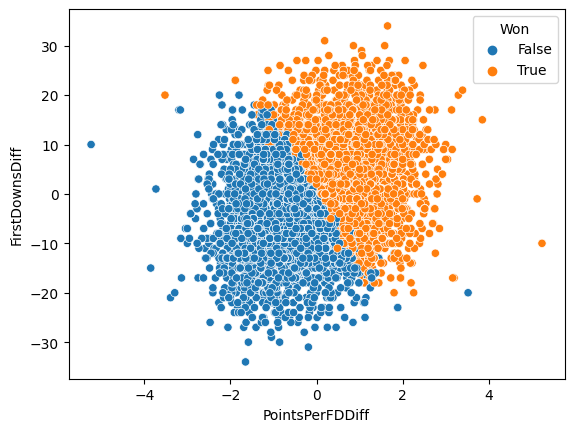

In [75]:
sn.scatterplot(data=stats_df, x='PointsPerFDDiff', y='FirstDownsDiff', hue='Won')


<AxesSubplot: xlabel='PointsEffDiff', ylabel='PointsPerFDDiff'>

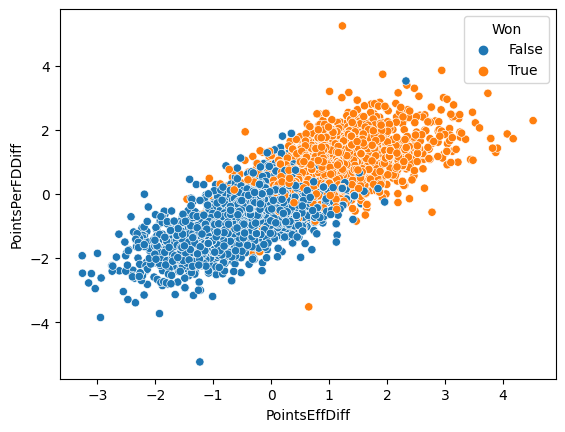

In [76]:
sn.scatterplot(data=stats_df, x='PointsEffDiff', y='PointsPerFDDiff', hue='Won')

<AxesSubplot: xlabel='PointsEffDiff', ylabel='FirstDownsDiff'>

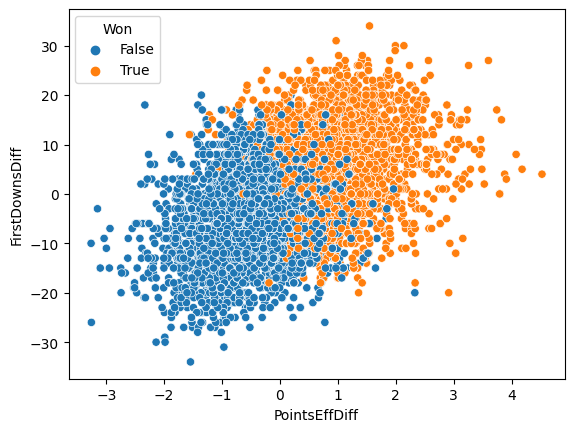

In [77]:
sn.scatterplot(data=stats_df, x='PointsEffDiff', y='FirstDownsDiff', hue='Won')


In [78]:
winClassifier = chooseModel([RandomForestClassifier()], ['PointsEffDiff', 'PointsPerFDDiff', 'FirstDownsDiff'])

RandomForestClassifier Score: 0.9731205824907658

Based on these results, the Classification Model we will use is RandomForestClassifier


The next step is to build a model or models that accurately predict these three highly descriptive features.

 * PointsEffDiff
 * PointsPerFDDiff
 * FirstDownsDiff


***
### Predicting features of later games within a season

The data now needs to be organized in more of a time series fashion and grouped by season. Samples taken are deliberately spread out over many seasons to help provide the best generalization.

In [79]:
#do some ETL stuff to get things in order
#take training sample by every other year or every two years
####train on front half, test on back half?
#?????????????????????????????????????????????